In [15]:
import itertools
import logging
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq 

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
#from pandas.tseries.offsets import DateOffset

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

warnings.filterwarnings("ignore")
logger = logging.getLogger()
#logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.ERROR)


In [2]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [3]:
apple = query_ticker_data('AAPL').set_index('date')
netflix = query_ticker_data('NFLX').set_index('date')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard").set_index('date')
fb = query_ticker_data('FB').set_index('date')
microsoft = query_ticker_data('MSFT').set_index('date')
amazon = query_ticker_data('AMZN').set_index('date')
alphabet = query_ticker_data('GOOGL').set_index('date')
coke = query_ticker_data('KO').set_index('date')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [4]:
TARGET_DF = apple

In [5]:
vwap = TARGET_DF['volume_weighted_average_price']

In [6]:
TARGET_DF['simple_rtn'] = vwap.pct_change()
TARGET_DF['log_rtn'] = np.log(vwap/vwap.shift(1))

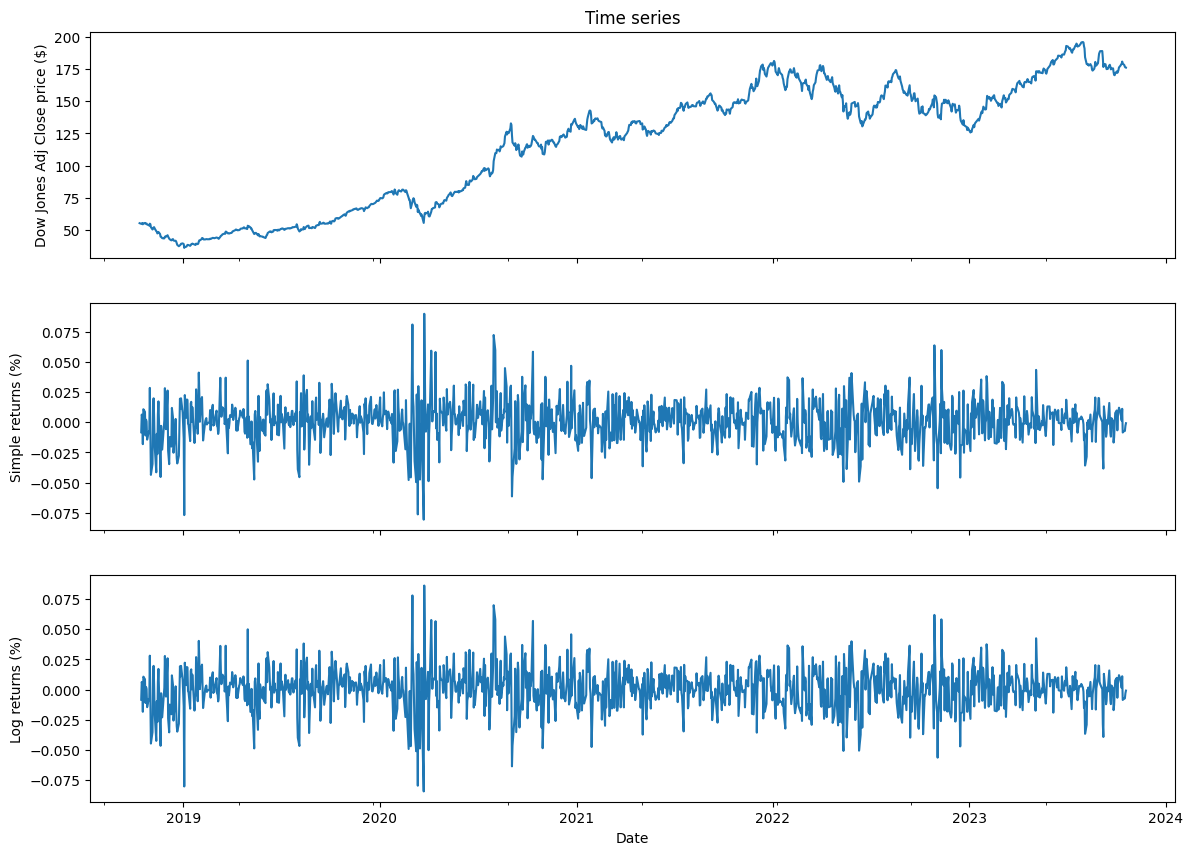

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Dow Jones Adj Close price ($)')
TARGET_DF.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
TARGET_DF.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')
plt.show()

In [8]:
hist = TARGET_DF[['volume_weighted_average_price']]
hist.reset_index(level=0, inplace=True)
hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

In [9]:
param_grid = { 
    "daily_seasonality": [False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [False, True],
    "growth": ["linear"],
    "seasonality_mode": ["additive", "multiplicative"],    
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    #m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
    #m.add_country_holidays("US")
    m = m.fit(hist)  # Fit model with given params
    df_cv = cross_validation(m, initial='1095 days', period='63 days', horizon = '252 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

14:04:58 - cmdstanpy - INFO - Chain [1] start processing
14:04:58 - cmdstanpy - INFO - Chain [1] done processing
14:04:59 - cmdstanpy - INFO - Chain [1] start processing
14:04:59 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing
14:05:00 - cmdstanpy - INFO - Chain [1]

,daily_seasonality,weekly_seasonality,yearly_seasonality,growth,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,rmse
0,False,False,False,linear,additive,0.001,0.01,33.398693
1,False,False,False,linear,additive,0.001,0.10,33.398693
2,False,False,False,linear,additive,0.001,1.00,33.398693
3,False,False,False,linear,additive,0.001,10.00,33.398693
4,False,False,False,linear,additive,0.010,0.01,31.346397
...,...,...,...,...,...,...,...,...
59,False,False,True,linear,multiplicative,0.100,10.00,34.454338
60,False,False,True,linear,multiplicative,0.500,0.01,36.457559
61,False,False,True,linear,multiplicative,0.500,0.10,44.154015
62,False,False,True,linear,multiplicative,0.500,1.00,44.068757


In [10]:
# Python
best_params = all_params[np.argmin(rmses)]
best_params

{'daily_seasonality': False,
 'weekly_seasonality': False,
 'yearly_seasonality': False,
 'growth': 'linear',
 'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.01}

14:07:21 - cmdstanpy - INFO - Chain [1] start processing
14:07:21 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
             ds        yhat  yhat_lower  yhat_upper
1519 2024-10-14  200.392575  186.243668  216.009058
1520 2024-10-15  200.454869  185.237071  216.133960
1521 2024-10-16  200.517163  184.699934  216.237404
1522 2024-10-17  200.579457  184.905175  217.256222
1523 2024-10-18  200.641751  184.070610  216.885270


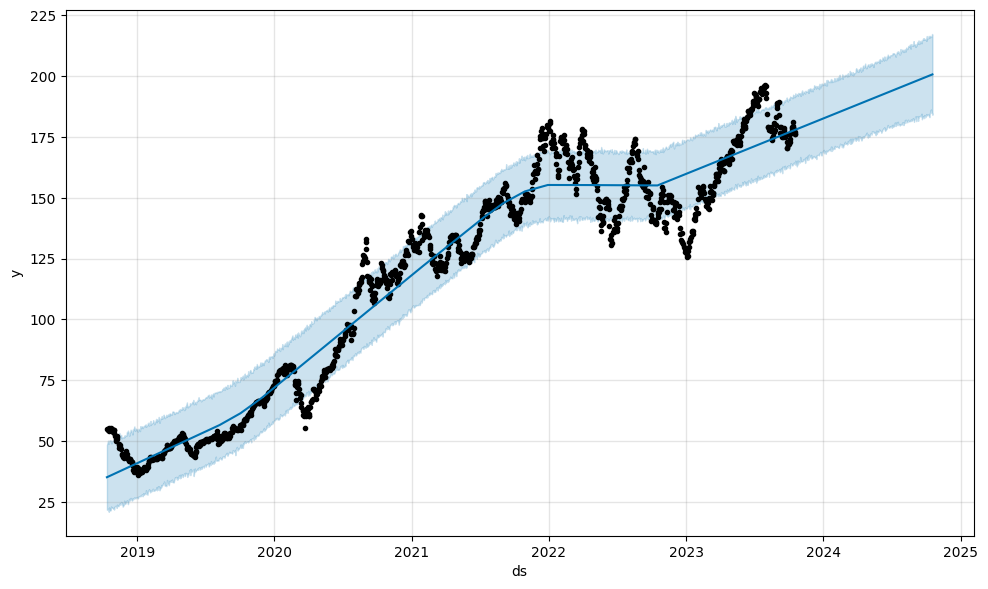

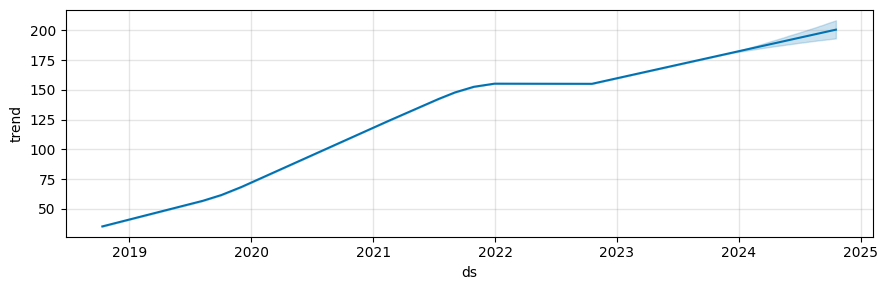

In [11]:
"""
param ={
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "growth": "linear",
    "seasonality_mode": "additive",
    'changepoint_prior_scale': 0.01, 
    'seasonality_prior_scale': 10.0
}
"""

m = Prophet(**best_params)
#m= m.add_seasonality(name="monthly", period=30, fourier_order=10)
#m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
#m.add_country_holidays("US")
m.fit(hist)
future = m.make_future_dataframe(periods=365, freq='D')
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
print("Predicted Data")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

#plot_plotly(m, forecast, figsize=(1000,600)) # 
#plot_components_plotly(m, forecast, figsize=(1000,600))

In [12]:
df_cv = cross_validation(m, initial='1095 days', period='90 days', horizon = '365 days', parallel="processes")

14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:22 - cmdstanpy - INFO - Chain [1] done processing
14:07:22 - cmdstanpy - INFO - Chain [1] done processing
14:07:22 - cmdstanpy - INFO - Chain [1] done processing
14:07:22 - cmdstanpy - INFO - Chain [1] done processing
14:07:22 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,191.871265,13.851760,9.458586,0.062752,0.035369,0.059003,0.7440
1,37 days,191.756785,13.847627,9.464841,0.062714,0.035880,0.058997,0.7440
2,38 days,192.730984,13.882759,9.526750,0.063027,0.035947,0.059346,0.7360
3,39 days,198.170223,14.077295,9.649031,0.063864,0.035880,0.060085,0.7360
4,40 days,202.704703,14.237440,9.763409,0.064678,0.035880,0.060817,0.7376
...,...,...,...,...,...,...,...,...
325,361 days,2177.758865,46.666464,41.334495,0.277252,0.289542,0.239601,0.1280
326,362 days,2172.989871,46.615339,41.295303,0.276790,0.272746,0.239489,0.1220
327,363 days,2179.224826,46.682168,41.385191,0.277091,0.281198,0.239843,0.1152
328,364 days,2157.859931,46.452771,41.197443,0.275165,0.281198,0.238577,0.1100


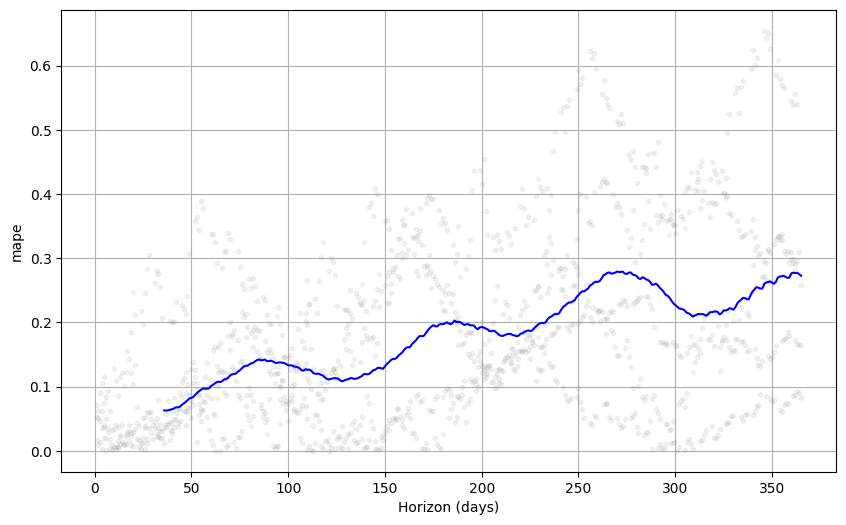

In [16]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [17]:
duckdb.sql("select cutoff, count(*) from df_cv group by 1 order by 1").df()

,cutoff,count_star()
0,2021-10-24,252
1,2022-01-22,250
2,2022-04-22,250
3,2022-07-21,251
4,2022-10-19,251


In [18]:
df_cv[df_cv.cutoff=="2022-10-19"]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1003,2022-10-20,154.448916,143.878898,166.783165,144.2072,2022-10-19
1004,2022-10-21,154.429238,143.270807,165.324260,145.5191,2022-10-19
1005,2022-10-24,154.370202,143.264970,166.325045,148.3743,2022-10-19
1006,2022-10-25,154.350524,142.678319,165.960344,151.4347,2022-10-19
1007,2022-10-26,154.330845,142.885964,165.724315,150.0488,2022-10-19
...,...,...,...,...,...,...
1249,2023-10-13,147.404028,132.243071,162.638866,179.4154,2022-10-19
1250,2023-10-16,147.344993,133.008820,161.401819,178.1478,2022-10-19
1251,2023-10-17,147.325314,132.344565,161.772139,176.8623,2022-10-19
1252,2023-10-18,147.305636,131.344424,161.992520,176.3501,2022-10-19
